## Conclusion
1. Everything bears strictly **exercise-like** character.
2. The idea is to predict `time of a trip` - here is used **external dataset** with `distance` and `speed` of **THESE TRIPS** (merged by id)  
- **realistically, in order to achieve a proper result, a system of closest coordinate point matching should be used** for proper inference (prediction)
    - simple (other) features dont't give a proper result

## 1. Uploading data + prepare (according to EDA notebook)

In [2]:
import os
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import random
DEFAULT_RANDOM_SEED = 2021
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

In [3]:
def load_train_test(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    train['dset'] = 'train'
    test['dset'] = 'test'
    test['dropoff_datetime'] = pd.NaT
    test['trip_duration'] = pd.NA

    df = pd.concat([train, test], ignore_index=True)
    df['dset'] = pd.Categorical(df['dset'], categories=['train', 'test'])
    return df


# Adding geospatial feature --------------------------------------------------------------------------
def add_geospatial_features(df):
    import numpy as np

    JFK = (-73.778889, 40.639722)
    LGA = (-73.872611, 40.77725)

    def bearing(p1, p2):
        p1 = np.asarray(p1)
        p2 = np.asarray(p2)

        if p1.shape != p2.shape or p1.ndim != 2 or p1.shape[1] != 2:
            raise ValueError("p1 and p2 must both be (N, 2) arrays with columns [lon, lat].")

        lon1, lat1 = p1[:, 0], p1[:, 1]
        lon2, lat2 = p2[:, 0], p2[:, 1]

        # Convert to radians
        lon1 = np.deg2rad(lon1); lat1 = np.deg2rad(lat1)
        lon2 = np.deg2rad(lon2); lat2 = np.deg2rad(lat2)

        dlon = lon2 - lon1

        x = np.sin(dlon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

        ang = np.arctan2(x, y)                 # radians, [-pi, pi]
        brg = (np.rad2deg(ang) + 360.0) % 360.0  # degrees, [0, 360)

        # Identical points → undefined bearing
        same = (np.isclose(lon1, lon2) & np.isclose(lat1, lat2))
        brg = brg.astype(float)
        brg[same] = np.nan

        return brg

    def dist_haversine(pick, drop):
        R = 6371000  # Earth radius in meters

        pick = np.asarray(pick)
        drop = np.asarray(drop)

        lon1, lat1 = np.deg2rad(pick[:, 0]), np.deg2rad(pick[:, 1])
        lon2, lat2 = np.deg2rad(drop[:, 0]), np.deg2rad(drop[:, 1])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return R * c

    pick = df[['pickup_longitude', 'pickup_latitude']].to_numpy()
    drop = df[['dropoff_longitude', 'dropoff_latitude']].to_numpy()

    df['bearing'] = bearing(pick, drop)
    df['dist'] = dist_haversine(pick, drop)
    df['jfk_dist_pick'] = dist_haversine(pick, np.tile(JFK, (len(pick), 1)))
    df['jfk_dist_drop'] = dist_haversine(drop, np.tile(JFK, (len(drop), 1)))
    df['lg_dist_pick']  = dist_haversine(pick, np.tile(LGA, (len(pick), 1)))
    df['lg_dist_drop']  = dist_haversine(drop, np.tile(LGA, (len(drop), 1)))
    return df


# Adding temporal features -----------------------------------------------------------------------
def add_temporal_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
    df['date'] = df['pickup_datetime'].dt.normalize()
    df['month'] = df['pickup_datetime'].dt.month.astype('Int64')
    df['hour'] = df['pickup_datetime'].dt.hour.astype('Int64')
    df['wday'] = df['pickup_datetime'].dt.dayofweek.map(lambda d: calendar.day_abbr[d])
    df['wday'] = pd.Categorical(df['wday'], categories=["Sun", "Sat", "Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True).codes
    
    df['minute'] = df['pickup_datetime'].dt.minute.astype('Int64')
    df['minute_oftheday'] = df['hour'] * 60 + df['minute']

    work_days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
    df['work'] = ((df['hour'].between(8, 18)) & (df['wday'].isin(range(2, 7)))).astype(int)

    # Blizzard flag
    start = pd.to_datetime("2016-01-22")
    end = pd.to_datetime("2016-01-29")
    df['blizzard'] = ((df['date'] >= start) & (df['date'] <= end)).astype(int)
    return df


# Load "weather" external data ------------------------------------------------------------------
def load_weather_data(path):
    weather = pd.read_csv(path)
    weather['date'] = pd.to_datetime(weather['date'], dayfirst=True, errors='coerce').dt.normalize()
    weather['rain'] = pd.to_numeric(weather['precipitation'].replace('T', '0.01'), errors='coerce')
    weather['s_fall'] = pd.to_numeric(weather['snow fall'].replace('T', '0.01'), errors='coerce')
    weather['s_depth'] = pd.to_numeric(weather['snow depth'].replace('T', '0.01'), errors='coerce')
    weather['all_precip'] = weather['s_fall'] + weather['rain']
    weather['has_snow'] = (weather['s_fall'] > 0) | (weather['s_depth'] > 0)
    weather['has_rain'] = weather['rain'] > 0
    weather['max_temp'] = weather['maximum temperature']
    weather['min_temp'] = weather['minimum temperature']
    return weather

def merge_weather(df, weather):
    cols = ["date", "rain", "s_fall", "all_precip", "has_snow", "has_rain", "s_depth", "max_temp", "min_temp"]
    return df.merge(weather[cols], on="date", how="left")


# Load & merge "fastest_routes" external dataset -----------------------------------------------
def load_fastest_routes(paths):
    dfs = [pd.read_csv(p) for p in paths]
    fr = pd.concat(dfs, ignore_index=True)
    fr = fr[[
        'id', 'total_distance', 'total_travel_time', 'number_of_steps',
        'step_direction', 'step_maneuvers'
    ]].copy()

    fr['fastest_speed'] = fr['total_distance'] / fr['total_travel_time'] * 3.6
    fr['step_direction'] = fr['step_direction'].fillna('').astype(str)
    fr['step_maneuvers'] = fr['step_maneuvers'].fillna('').astype(str)
    fr['left_turns'] = fr['step_direction'].str.count('left')
    fr['right_turns'] = fr['step_direction'].str.count('right')
    fr['turns'] = fr['step_maneuvers'].str.count('turn')
    return fr.drop(columns=['step_direction', 'step_maneuvers'])


def merge_fastest_routes(df, fr):
    df = df.drop(columns=['total_travel_time', 'total_distance'], errors='ignore')
    return df.merge(fr, on='id', how='left')

def categorical_encoding(df, features):
    for feat in features:
        df = pd.concat([df, pd.get_dummies(df[feat], prefix=feat)], axis=1)
    df.drop(features, axis=1, inplace=True)
    return df

# Add categorical and proximity flags ----------------------------------------------------------
def finalize_features(df):
    df['store_and_fwd_flag'] = pd.factorize(df['store_and_fwd_flag'])[0]
    df['vendor_id'] = df['vendor_id'].astype('Int64')
    df['jfk_trip'] = ((df['jfk_dist_pick'] < 2000) | (df['jfk_dist_drop'] < 2000)).astype(int)
    df['lg_trip'] = ((df['lg_dist_pick'] < 2000) | (df['lg_dist_drop'] < 2000)).astype(int)

    # categorical encoding
    cat_feat_enc = ['vendor_id', 'store_and_fwd_flag']
    df = categorical_encoding(df, cat_feat_enc)

    return df

In [4]:
df = load_train_test('data/train.csv', 'data/test.csv')

df = add_geospatial_features(df)    # Geo features 
df = add_temporal_features(df)      # Custom features

# Weather external - EXTERNAL DATA
weather = load_weather_data('data/weather_data_nyc_centralpark_2016.xls')
df = merge_weather(df, weather)

# Fastest_routes - EXTERNAL DATA
fr = load_fastest_routes([
    'data/fastest_routes_train_part_1.csv',
    'data/fastest_routes_train_part_2.csv'
])
df = merge_fastest_routes(df, fr)

# Polishing features 
df = finalize_features(df)

df.head(5)

,id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dset,bearing,dist,jfk_dist_pick,jfk_dist_drop,lg_dist_pick,lg_dist_drop,date,month,hour,wday,minute,minute_oftheday,work,blizzard,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,number_of_steps,fastest_speed,left_turns,right_turns,turns,jfk_trip,lg_trip,vendor_id_1,vendor_id_2,store_and_fwd_flag_0,store_and_fwd_flag_1
0,id2875421,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,455,train,99.970,1498.521,22290.053,21001.874,9282.498,7856.447,2016-03-14,3,17,2,24,1044,1,0,0.290,0.000,0.290,False,True,0.000,51,40,2009.100,164.900,5.000,43.861,1.000,1.000,1.000,0,0,False,True,True,False
1,id2377394,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,663,train,242.846,1805.507,20236.314,21197.232,10047.523,11852.300,2016-06-12,6,0,0,43,43,0,0,0.000,0.000,0.000,False,False,0.000,83,62,2513.200,332.000,6.000,27.252,2.000,2.000,2.000,0,0,True,False,True,False
2,id3858529,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,2124,train,200.320,6385.098,21804.112,20637.271,9082.822,13445.949,2016-01-19,1,11,3,35,695,1,0,0.000,0.000,0.000,True,False,0.010,28,16,11060.800,767.600,16.000,51.875,5.000,7.000,9.000,0,0,False,True,True,False
3,id3504673,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,429,train,187.262,1485.498,21437.495,21044.602,13213.305,14140.080,2016-04-06,4,19,4,32,1172,0,0,0.000,0.000,0.000,False,False,0.000,48,30,1779.400,235.800,4.000,27.166,2.000,1.000,1.000,0,0,False,True,True,False
4,id2181028,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,435,train,179.474,1188.588,23644.565,22794.603,8640.673,8466.550,2016-03-26,3,13,1,30,810,0,0,0.000,0.000,0.000,False,False,0.000,55,38,1614.900,140.100,5.000,41.496,2.000,2.000,3.000,0,0,False,True,True,False


In [5]:
train_cols = [
    # Geospatial
    "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "bearing", "dist",

    # Temporal
    "month", "hour", "wday", "work", "blizzard", "minute", "minute_oftheday",

    # Weather
    "rain", "s_fall", "all_precip", "has_snow", "has_rain", "s_depth",
    "max_temp", "min_temp",

    # Routing
    "total_distance", "total_travel_time", "fastest_speed",
    "number_of_steps", "left_turns", "right_turns", "turns",

    # Categorical Encodings
    "vendor_id_1", "vendor_id_2",
    "store_and_fwd_flag_0", "store_and_fwd_flag_1",

    # Proximity Flags
    "jfk_trip", "lg_trip",

    "passenger_count",
]

id_col = ["id"]
aux_cols = ["dset"]
clean_cols = ["jfk_dist_drop", "jfk_dist_pick", "lg_dist_pick", "lg_dist_drop"]
target = ["trip_duration"]

test_id = df.loc[df['dset'] == 'test', id_col].copy()
cols = train_cols + target + aux_cols + clean_cols

df_train = df[cols].copy()
df_train.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,bearing,dist,month,hour,wday,work,blizzard,minute,minute_oftheday,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,fastest_speed,number_of_steps,left_turns,right_turns,turns,vendor_id_1,vendor_id_2,store_and_fwd_flag_0,store_and_fwd_flag_1,jfk_trip,lg_trip,passenger_count,trip_duration,dset,jfk_dist_drop,jfk_dist_pick,lg_dist_pick,lg_dist_drop
0,-73.982,40.768,-73.965,40.766,99.970,1498.521,3,17,2,1,0,24,1044,0.290,0.000,0.290,False,True,0.000,51,40,2009.100,164.900,43.861,5.000,1.000,1.000,1.000,False,True,True,False,0,0,1,455,train,21001.874,22290.053,9282.498,7856.447
1,-73.980,40.739,-73.999,40.731,242.846,1805.507,6,0,0,0,0,43,43,0.000,0.000,0.000,False,False,0.000,83,62,2513.200,332.000,27.252,6.000,2.000,2.000,2.000,True,False,True,False,0,0,1,663,train,21197.232,20236.314,10047.523,11852.300
2,-73.979,40.764,-74.005,40.710,200.320,6385.098,1,11,3,1,0,35,695,0.000,0.000,0.000,True,False,0.010,28,16,11060.800,767.600,51.875,16.000,5.000,7.000,9.000,False,True,True,False,0,0,1,2124,train,20637.271,21804.112,9082.822,13445.949
3,-74.010,40.720,-74.012,40.707,187.262,1485.498,4,19,4,0,0,32,1172,0.000,0.000,0.000,False,False,0.000,48,30,1779.400,235.800,27.166,4.000,2.000,1.000,1.000,False,True,True,False,0,0,1,429,train,21044.602,21437.495,13213.305,14140.080
4,-73.973,40.793,-73.973,40.783,179.474,1188.588,3,13,1,0,0,30,810,0.000,0.000,0.000,False,False,0.000,55,38,1614.900,140.100,41.496,5.000,2.000,2.000,3.000,False,True,True,False,0,0,1,435,train,22794.603,23644.565,8640.673,8466.550


## 2. Model training
- **Always choose 3-4 models to test quickly - simple, robust, high-performance**

### Personal advices


| Model | ✅ Suitable For | ❌ Not Suitable For | ⚠️ Lacks Compared To Others |
|-------|----------------|---------------------|-----------------------------|
| **Linear Regression** | - Simple linear relationships<br>- Small datasets<br>- Fast baseline | - Non-linear patterns<br>- High-dimensional data<br>- Categorical variables (without encoding)<br>- Outliers | - No regularization<br>- Poor generalization<br>- No feature selection |
| **Polynomial Regression** | - Curved relationships<br>- Feature expansion | - High-dimensional data<br>- Overfitting risk<br>- Sparse features | - Sensitive to noise<br>- Poor extrapolation<br>- Needs careful degree tuning |
| **Ridge L2 / Lasso L1 / ElasticNet L1+L2** | - Linear relationships<br>- Regularization<br>- Feature selection (Lasso) | - Non-linear patterns<br>- Categorical variables<br>- Complex interactions | - Still linear<br>- Needs encoding<br>- No interaction modeling |
| **Decision Tree** | - Non-linear relationships<br>- Mixed features<br>- Fast training<br>- Interpretability | - Noisy data<br>- Unstable with small changes<br>- Poor generalization | - No ensemble power<br>- Prone to overfitting |
| **Random Forest** | - Non-linear relationships<br>- Robust to outliers<br>- Mixed features<br>- Feature importance | - Very high-dimensional sparse data<br>- Long training time<br>- Hard to tune | - Slower than boosting<br>- Less accurate on complex patterns |
| **Gradient Boosting (XGBoost, LightGBM, CatBoost)** | - Complex patterns<br>- Large datasets<br>- Mixed features<br>- Missing values<br>- High accuracy | - Real-time applications<br>- Interpretability<br>- Overfitting if not tuned | - Harder to tune<br>- More compute-intensive |
| **K-Nearest Neighbors (KNN)** | - Small datasets<br>- Simple patterns<br>- No training time | - Large datasets<br>- High-dimensional data<br>- Irrelevant features<br>- Noisy data | - No interpretability<br>- Sensitive to scaling<br>- No feature importance |
| **Support Vector Machines (SVM)** | - Small datasets<br>- Complex boundaries<br>- High-dimensional data (with kernels) | - Large datasets<br>- Mixed feature types<br>- Regression with noise | - Slow training<br>- Hard to tune<br>- No probabilistic output |
| **Neural Networks (MLP)** | - Complex patterns<br>- Large datasets<br>- Integration with other data types | - Tabular data<br>- Small datasets<br>- Interpretability | - Hard to tune<br>- Requires lots of data<br>- Black-box behavior |
| **Stacking / Blending / Ensembling** | - Combining strengths of multiple models<br>- Reducing bias/variance<br>- Improving generalization | - Small datasets<br>- Real-time prediction<br>- Interpretability | - Complex setup<br>- Long training time<br>- Hard to debug |
| **Bayesian Regression** | - Uncertainty estimation<br>- Small datasets<br>- Probabilistic modeling | - Large datasets<br>- High-dimensional data<br>- Complex non-linear patterns | - Slower<br>- Less scalable<br>- Requires priors |
| **Poisson / Gamma Regression** | - Count data<br>- Skewed distributions<br>- Non-negative targets | - Continuous symmetric targets<br>- Negative values | - Limited flexibility<br>- Requires distribution assumptions |
| **Quantile Regression** | - Predicting percentiles<br>- Robust to outliers<br>- Non-normal errors | - Mean prediction tasks<br>- Small datasets | - Slower<br>- Less intuitive<br>- No probabilistic output |



####

1. Goal
- `Regression | Classification | Probability prediction`
  - `Simplicity & speed` → Linear models | Trees
  - `Interpretability` → Ridge | Lasso | Decision Trees
  - `Robustness` → Random Forest | LightGBM
  - `Accuracy` → Boosting | Ensembling
  - `Uncertainty` → Bayesian | Quantile Regression
- Regression → RMSE, MAE, R²
- Classification → Accuracy, F1, ROC-AUC
2. Features transformations
- `Numerical` → Scalings
  - Scaling - Linear models, SVM, KNN, NN
  - No scaling - Tree-based 
- `Categorical`→ Encodings
  - Few categories → One-hot encoding
  - Many categories → Label encoding or CatBoost
    - Tree models handle encoded categories well
- `Cyclic` → PCA, cyclic transformations
  - Use sine/cosine transforms for linear models
    - Tree models can handle raw values
- `NaNs` → Imputations (Mean, Median, KNNImputer)
  - Impute or use models that handle them (LightGBM, XGBoost)
3. Data (size & complexity)
- < 10k: Ridge, Lasso, Decision Tree, SVM
- 10-100k: Random Forest, LightGBM, XGBoost
- \> 100k: 
    - avoid KNN, SVM, NN unless optimized
    - LightGBM | XGBoost | regularized Linear models
4. Features amount
- < 20
  - Most models will work (try Ridge, Decision Tree, Random Forest)
- \> 50
  - Use regularization (Ridge, Lasso)
  - Use feature importance (RF, XGB)
  - Consider dimensionality reduction (PCA)
5. Changing
- Overfit → regularization / simpler model / early stopping
- Slow? → linear / tree-based models
- Complex? → Reduce features / simplify pipeline
- Opaque? → Use interpretable models or SHAP



###

In [34]:
from sklearn.model_selection import train_test_split

# Split train/test
train = df_train.loc[df_train['dset'] == 'train'].drop(columns=aux_cols)
test = df_train.loc[df_train['dset'] == 'test'].drop(columns=aux_cols + clean_cols + target)

# Transform target into "log"
train = train[train['trip_duration'] < 24*3600]
train['trip_duration'] = np.log1p(train['trip_duration'].astype(float))

# Dropping columns
#cols_2_drop = ['total_travel_time', 'total_distance']
#train = train.drop(columns=['jfk_dist_drop', 'lg_dist_drop'], errors='ignore')

# Removing close to inf values with NaN 
train_cleaned = train.replace([np.inf, -np.inf], np.nan).dropna()

train_part, valid = train_test_split(train_cleaned, train_size=0.8, random_state=4321)
valid = valid.drop(columns=clean_cols)

# Removing anomaly trips
train_part = train_part[
    (train_part['jfk_dist_pick'] < 300000) & (train_part['jfk_dist_drop'] < 300000) \
].drop(columns=clean_cols)

# dropping columns
foo = train_part.drop(columns=["trip_duration"]).copy()
bar = valid.drop(columns=["trip_duration"]).copy()

In [67]:
from sklearn.metrics import mean_squared_error

def clean_from_NaNs(train):

    train_cleaned = train.dropna()
    train_part_cleaned, valid_cleaned = train_test_split(train_cleaned, train_size=0.8, random_state=4321)
    
    valid_cleaned = valid_cleaned.drop(columns=clean_cols)
    train_part_cleaned = train_part_cleaned[
        (train_part_cleaned['jfk_dist_pick'] < 300000) & (train_part_cleaned['jfk_dist_drop'] < 300000) \
    ].drop(columns=clean_cols)

    foo_cleaned = train_part_cleaned.drop(columns=["trip_duration"]).copy()
    bar_cleaned = valid_cleaned.drop(columns=["trip_duration"]).copy()

    return train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned

def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    print(f"{name} RMSE: {rmse:.4f}")
    return model, preds, rmse

In [42]:
display(foo.head(5)) # TRAIN
display(bar.head(5)) # VALID
bar.shape

,pickup_longitude,pickup_latitude,bearing,dist,month,hour,wday,work,blizzard,minute,minute_oftheday,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,fastest_speed,number_of_steps,left_turns,right_turns,turns,vendor_id_1,vendor_id_2,store_and_fwd_flag_0,store_and_fwd_flag_1,jfk_trip,lg_trip
117177,-73.964,40.771,205.499,2844.032,5,17,5,1,0,52,1072,0.000,0.000,0.000,False,False,0.000,73,54,3740.100,318.100,42.327,5.000,2.000,2.000,3.000,True,False,True,False,0,0
125666,-73.997,40.737,16.535,3314.189,1,1,6,0,1,19,79,0.010,0.200,0.210,True,True,0.000,30,21,4697.500,510.900,33.100,5.000,1.000,3.000,3.000,True,False,True,False,0,0
1346790,-73.991,40.756,43.838,4113.155,4,6,3,0,0,0,360,0.000,0.000,0.000,False,False,0.000,73,55,5060.800,480.300,37.932,6.000,3.000,2.000,4.000,True,False,True,False,0,0
538387,-73.944,40.787,218.333,1311.267,5,16,2,1,0,3,963,0.020,0.000,0.020,False,True,0.000,78,56,1517.300,142.600,38.305,4.000,1.000,1.000,2.000,True,False,True,False,0,0
1338774,-73.966,40.762,226.774,1004.518,6,7,5,0,0,31,451,0.000,0.000,0.000,False,False,0.000,78,62,1302.600,133.200,35.205,5.000,3.000,0.000,3.000,True,False,True,False,0,0


,pickup_longitude,pickup_latitude,bearing,dist,month,hour,wday,work,blizzard,minute,minute_oftheday,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,fastest_speed,number_of_steps,left_turns,right_turns,turns,vendor_id_1,vendor_id_2,store_and_fwd_flag_0,store_and_fwd_flag_1,jfk_trip,lg_trip
551486,-73.989,40.720,132.824,6472.565,2,22,1,0,0,35,1355,0.000,0.000,0.000,False,False,0.000,61,39,8586.200,739.300,41.810,17.000,4.000,9.000,11.000,False,True,True,False,0,0
820590,-73.777,40.645,6.348,13041.190,4,22,5,0,0,22,1342,0.090,0.000,0.090,False,True,0.000,58,48,20342.000,1045.100,70.071,12.000,3.000,6.000,3.000,False,True,True,False,1,0
722860,-73.986,40.727,325.641,2143.313,3,21,3,0,0,6,1266,0.000,0.000,0.000,False,False,0.000,56,35,2669.400,351.300,27.355,7.000,2.000,2.000,3.000,True,False,True,False,0,0
396397,-73.974,40.763,298.666,1460.101,5,15,3,1,0,1,901,0.000,0.000,0.000,False,False,0.000,85,71,1460.500,128.600,40.885,2.000,0.000,0.000,0.000,True,False,True,False,0,0
757515,-74.010,40.730,38.791,4306.941,1,7,2,0,0,49,469,0.000,0.000,0.000,False,False,0.000,40,26,7009.700,628.800,40.132,7.000,0.000,4.000,3.000,True,False,True,False,0,0


(291728, 32)

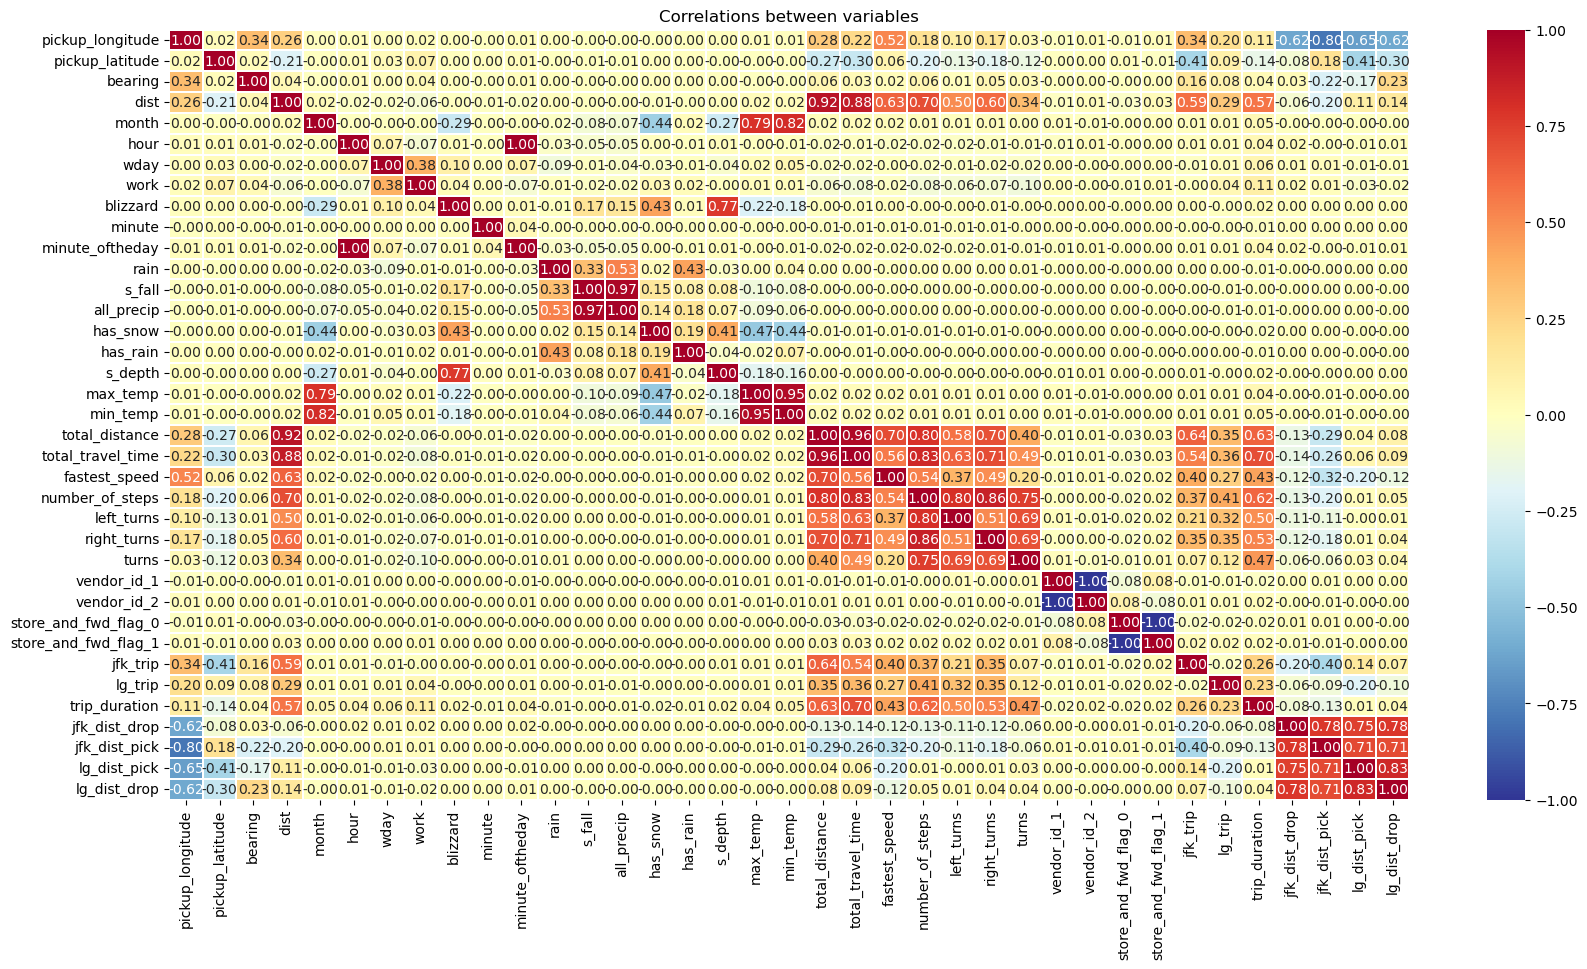

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

#Correlations between variables
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(data=train.corr(), annot=True, fmt=".2f", cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');
plt.show()

### 1. Simple - `rmse = 0.462` (polynomial)
- Polynomial + Ridge/L2 
- **Too many features to handle, also removing NaN values**

**MUST HAVES**
- `Linearity` - between X and Y
- `Independence` - of residuals
- `Homoscedasticity` - constant variance of samples
- `Normality` - of residuals
- `No autocorrelation`

#### Ridge Regression - `rmse 0.462`

In [77]:
from sklearn.linear_model import Ridge

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train)
ridge = Ridge(alpha=1.0)

ridge_model, ridge_preds, rmse = evaluate_model(
    ridge,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Ridge Regression"
)

Ridge Regression RMSE: 0.4619


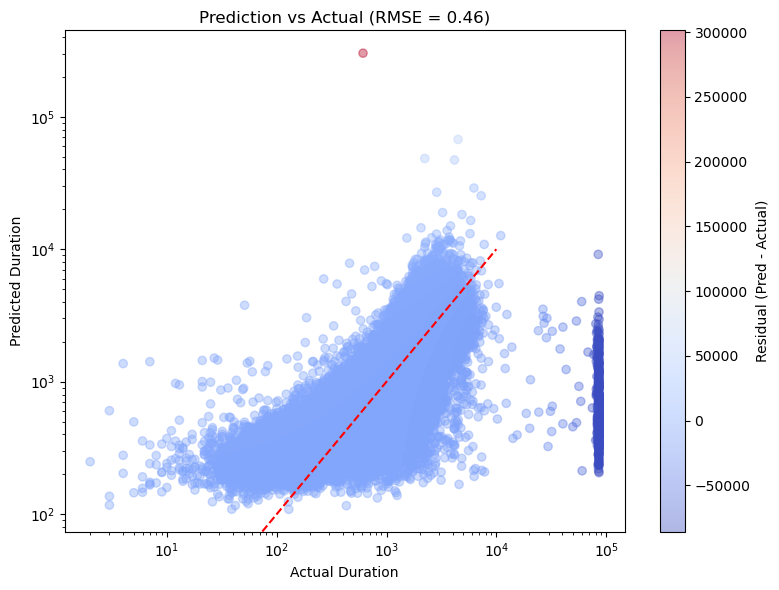

In [78]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(ridge_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

#### Polynomial - `rmse 0.462`

In [86]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train_cleaned)
poly_model = make_pipeline(
    PolynomialFeatures(degree=1),
    StandardScaler(),
    Ridge(alpha=1.0)
)

poly_model, poly_preds, rmse = evaluate_model(
    poly_model,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Polynomial Ridge Regression"
)

Polynomial Ridge Regression RMSE: 0.4619


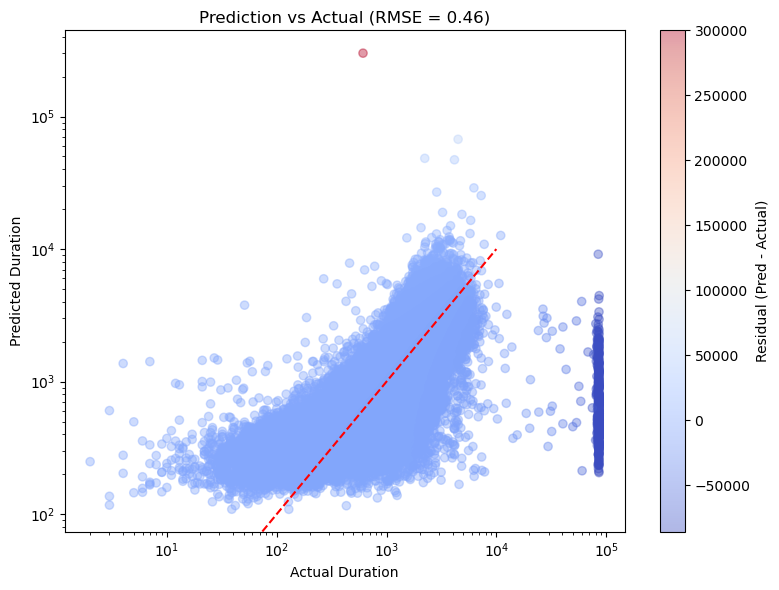

In [87]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(poly_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### 2. Robust `rmse = 0.377`
- Random Forest

#### Random Forest - `rmse 0.3764`

In [73]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model, rf_preds, rmse = evaluate_model(
    rf,
    foo, train_part['trip_duration'],
    bar, valid['trip_duration'],
    name="Random Forest"
)

Random Forest RMSE: 0.3764


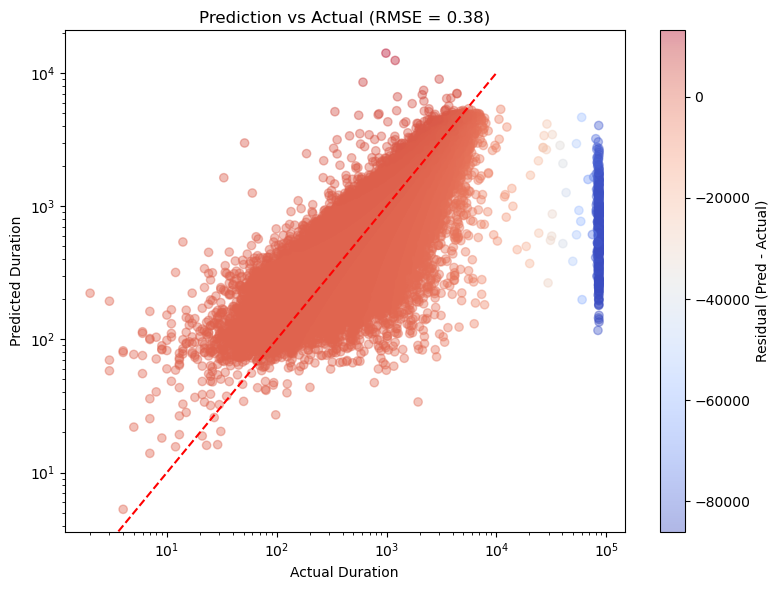

In [74]:
actual = np.expm1(valid["trip_duration"])
preds = np.expm1(rf_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### 3. High-performance `rmse = 0.356`
- XGBoost
- CatBoost
- LightGBM

#### LightGBM - `rmse = 0.37`

In [68]:
import lightgbm as lgb
from lightgbm.callback import early_stopping

lgb_params = {
   'metric': 'rmse',
   'is_training_metric': True,
   'verbose': 1
   }

X_train = foo.copy()
X_valid = bar.copy()
y_train = train_part['trip_duration']
y_valid = valid['trip_duration']

lgb_train = lgb.Dataset(X_train, train_part['trip_duration'])
lgb_test = lgb.Dataset(X_valid, valid['trip_duration'])

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[early_stopping(stopping_rounds=5)]
)

# Output
#     [100]	training's rmse: 0.370986	valid_1's rmse: 0.3712

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data points in the train set: 1157567, number of used features: 32
[LightGBM] [Info] Start training from score 6.482023
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.370986	valid_1's rmse: 0.3712


In [69]:
# Try LightGBM with sklearn API ------------
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as MSE

X_train = foo.copy()
X_valid = bar.copy()
y_train = train_part['trip_duration']
y_valid = valid['trip_duration']

lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_valid, y_valid))
print(np.sqrt(MSE(y_valid, lgbm.predict(X_valid))))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data points in the train set: 1157567, number of used features: 32
[LightGBM] [Info] Start training from score 6.482023
0.7629520500660013 0.7604444487739754
0.37119977463431675


#### CatBoost - `rmse = 0.356`

In [70]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=2500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100,
    random_state=42
)

cat_model.fit(
    foo, train_part['trip_duration'],
    eval_set=(bar, valid['trip_duration']),
    use_best_model=True
)

cat_preds = cat_model.predict(valid)

0:	learn: 0.7381333	test: 0.7346165	best: 0.7346165 (0)	total: 52.4ms	remaining: 2m 10s
100:	learn: 0.3999960	test: 0.3992249	best: 0.3992249 (100)	total: 4.47s	remaining: 1m 46s
200:	learn: 0.3857951	test: 0.3853609	best: 0.3853609 (200)	total: 8.72s	remaining: 1m 39s
300:	learn: 0.3787404	test: 0.3784751	best: 0.3784751 (300)	total: 13s	remaining: 1m 35s
400:	learn: 0.3741854	test: 0.3740804	best: 0.3740804 (400)	total: 17.2s	remaining: 1m 30s
500:	learn: 0.3708149	test: 0.3708639	best: 0.3708639 (500)	total: 21.5s	remaining: 1m 25s
600:	learn: 0.3683441	test: 0.3685891	best: 0.3685891 (600)	total: 25.7s	remaining: 1m 21s
700:	learn: 0.3662870	test: 0.3667146	best: 0.3667146 (700)	total: 29.9s	remaining: 1m 16s
800:	learn: 0.3645586	test: 0.3651732	best: 0.3651732 (800)	total: 34.2s	remaining: 1m 12s
900:	learn: 0.3631862	test: 0.3640017	best: 0.3640017 (900)	total: 38.4s	remaining: 1m 8s
1000:	learn: 0.3618644	test: 0.3628796	best: 0.3628796 (1000)	total: 42.6s	remaining: 1m 3s
1100

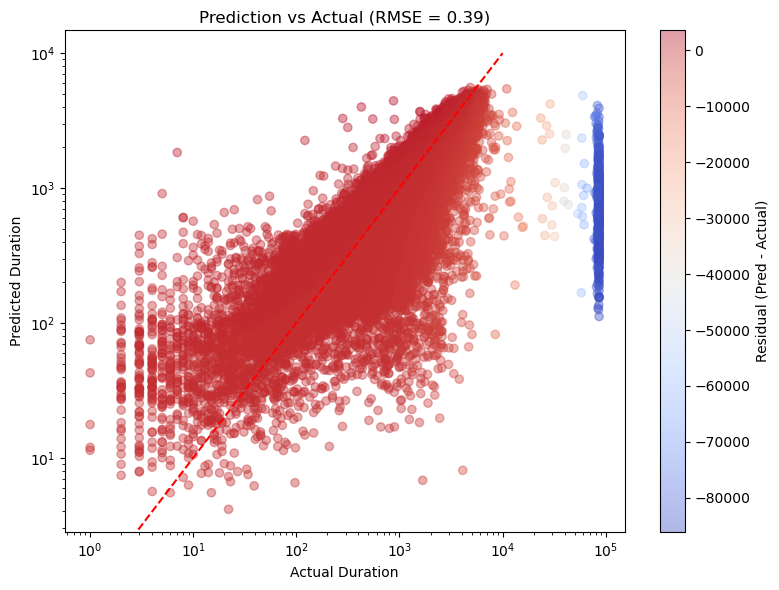

In [ ]:
actual = np.expm1(valid["trip_duration"])
preds = np.expm1(cat_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

#### XGBoost - `rmse = 0.357`

In [ ]:
import xgboost as xgb

# matrix creation
dtrain = xgb.DMatrix(foo, label=train_part["trip_duration"])
dvalid = xgb.DMatrix(bar, label=valid["trip_duration"])
dtest = xgb.DMatrix(test)

# hyperparemeters
xgb_params = {
    "colsample_bytree": 0.7,
    "subsample": 0.7,
    "booster": "gbtree",
    "max_depth": 5,
    "eta": 0.3,
    "eval_metric": "rmse",
    "objective": "reg:squarederror",  # reg:linear is deprecated
    "seed": 4321
}

watchlist = [(dtrain, "train"), (dvalid, "valid")]


# training
gb_dt = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=3050,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=10
)

# cross validation
xgb_cv = xgb.cv(
    params=xgb_params,
    dtrain=dvalid,
    num_boost_round=15,
    early_stopping_rounds=10,
    nfold=5,
    verbose_eval=False
)


[0]	train-rmse:0.61726	valid-rmse:0.61409
[10]	train-rmse:0.40275	valid-rmse:0.40227
[20]	train-rmse:0.38822	valid-rmse:0.38839
[30]	train-rmse:0.38192	valid-rmse:0.38243
[40]	train-rmse:0.37692	valid-rmse:0.37778
[50]	train-rmse:0.37344	valid-rmse:0.37450
[60]	train-rmse:0.37107	valid-rmse:0.37231
[70]	train-rmse:0.36854	valid-rmse:0.37003
[80]	train-rmse:0.36719	valid-rmse:0.36891
[90]	train-rmse:0.36594	valid-rmse:0.36803
[100]	train-rmse:0.36503	valid-rmse:0.36743
[110]	train-rmse:0.36411	valid-rmse:0.36694
[120]	train-rmse:0.36301	valid-rmse:0.36613
[130]	train-rmse:0.36188	valid-rmse:0.36523
[140]	train-rmse:0.36094	valid-rmse:0.36461
[150]	train-rmse:0.36019	valid-rmse:0.36419
[160]	train-rmse:0.35942	valid-rmse:0.36374
[170]	train-rmse:0.35853	valid-rmse:0.36307
[180]	train-rmse:0.35782	valid-rmse:0.36273
[190]	train-rmse:0.35691	valid-rmse:0.36216
[200]	train-rmse:0.35626	valid-rmse:0.36191
[210]	train-rmse:0.35545	valid-rmse:0.36161
[220]	train-rmse:0.35489	valid-rmse:0.36145

RMSE: 0.3572


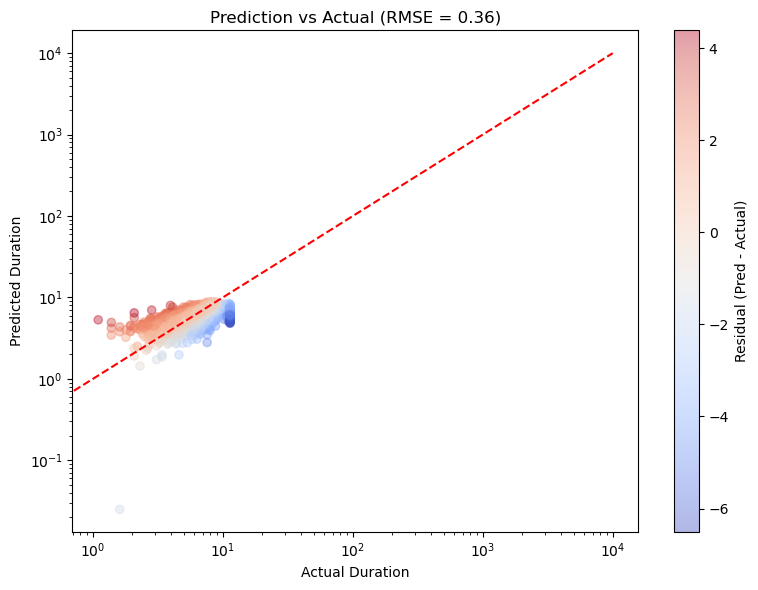

In [57]:
from sklearn.metrics import mean_squared_error

actual = valid["trip_duration"]
pred = gb_dt.predict(dvalid)
residual = pred - actual
rmse = np.sqrt(mean_squared_error(valid["trip_duration"], gb_dt.predict(dvalid)))
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(actual, pred, c=residual, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

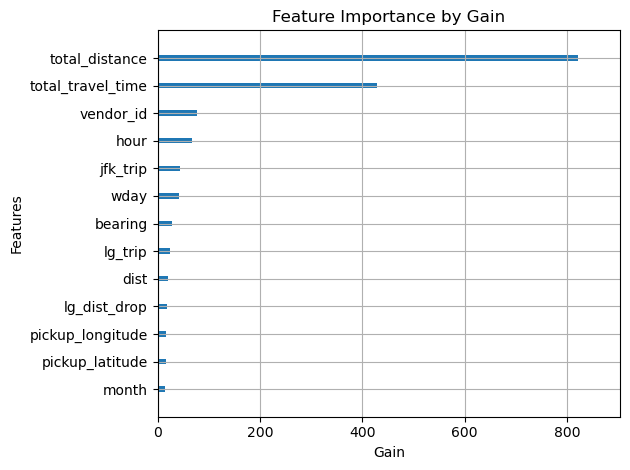

In [22]:
importance = xgb.plot_importance(gb_dt, importance_type='gain', show_values=False)
plt.title("Feature Importance by Gain")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### CV

In [ ]:
# Cross-validation on LightGBM model --------------------------
lgb_df = lgb.Dataset(X_train, y_train)
lgb.cv(lgb_params, lgb_df, stratified=False) #False is needed as it only works with classification

# Cross-validation on LightGBM model (sklearn API) ------------
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(lgbm, X_valid, y_valid, cv=5)
print(cv_score)
print(np.mean(cv_score))


# train
# [0.76156371 0.76204683 0.76430046 0.75973969 0.75773268]
# 0.7610766732812418

# valid
# [0.7576482  0.76525558 0.75559075 0.76079712 0.75421828]
# 0.7587019856548579

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data points in the train set: 926052, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data points in the train set: 926052, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data

## 3. Scikit-learn | Stacking `rmse = 0.3462` | Hyperparameter tuning `rmse = 0.345`
- no early stopping here

### Data + Model

In [6]:
import os
import numpy as np
import pandas as pd
import calendar
from sklearn.base import BaseEstimator, TransformerMixin

# 1.1 Geospatial features: bearing, haversine distances to dropoff/pickup, JFK & LGA
class GeoFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.JFK = np.array([ -73.778889, 40.639722 ])
        self.LGA = np.array([ -73.872611, 40.777250 ])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        pick = df[['pickup_longitude','pickup_latitude']].to_numpy()
        drop = df[['dropoff_longitude','dropoff_latitude']].to_numpy()

        # bearing
        lon1, lat1 = np.deg2rad(pick[:,0]), np.deg2rad(pick[:,1])
        lon2, lat2 = np.deg2rad(drop[:,0]), np.deg2rad(drop[:,1])
        dlon = lon2 - lon1
        x = np.sin(dlon)*np.cos(lat2)
        y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
        ang = np.arctan2(x, y)
        brg = (np.rad2deg(ang) + 360.0) % 360.0
        same = (np.isclose(lon1,lon2)&np.isclose(lat1,lat2))
        brg[same] = np.nan

        # haversine
        def hav(p, q):
            R = 6371000
            lon1, lat1 = np.deg2rad(p[:,0]), np.deg2rad(p[:,1])
            lon2, lat2 = np.deg2rad(q[:,0]), np.deg2rad(q[:,1])
            dlon, dlat = lon2-lon1, lat2-lat1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
            return R*c

        df['bearing']        = brg
        df['dist']           = hav(pick, drop)
        df['jfk_dist_pick']  = hav(pick, np.tile(self.JFK, (len(pick),1)))
        df['jfk_dist_drop']  = hav(drop, np.tile(self.JFK, (len(drop),1)))
        df['lg_dist_pick']   = hav(pick, np.tile(self.LGA, (len(pick),1)))
        df['lg_dist_drop']   = hav(drop, np.tile(self.LGA, (len(drop),1)))
        return df


# 1.2 Temporal: month, hour, wday, minute, minute_oftheday, work, blizzard
class TemporalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
        df['date']            = df['pickup_datetime'].dt.normalize()
        df['month']           = df['pickup_datetime'].dt.month
        df['hour']            = df['pickup_datetime'].dt.hour
        df['minute']          = df['pickup_datetime'].dt.minute
        df['minute_oftheday'] = df['hour']*60 + df['minute']

        # day of week → code 0–6
        df['wday'] = df['pickup_datetime'].dt.dayofweek
        # work hours flag (8–18 on Mon–Fri)
        df['work'] = ((df['hour'].between(8,18)) & (df['wday'].isin([0,1,2,3,4]))).astype(int)

        # blizzard Jan 22–29, 2016
        start = pd.to_datetime("2016-01-22")
        end   = pd.to_datetime("2016-01-29")
        df['blizzard'] = ((df['date']>=start)&(df['date']<=end)).astype(int)
        return df


# 1.3 Merge weather
class WeatherMerger(BaseEstimator, TransformerMixin):
    def __init__(self, weather_df):
        self.weather = weather_df.copy()
        # normalize date for merge
        self.weather['date'] = pd.to_datetime(self.weather['date'], dayfirst=True).dt.normalize()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        # coerce precipitation
        self.weather['rain']   = pd.to_numeric(self.weather['precipitation'].replace('T','0.01'))
        self.weather['s_fall'] = pd.to_numeric(self.weather['snow fall'].replace('T','0.01'))
        self.weather['s_depth']= pd.to_numeric(self.weather['snow depth'].replace('T','0.01'))
        self.weather['all_precip'] = self.weather['rain'] + self.weather['s_fall']
        self.weather['has_snow'] = (self.weather['s_fall']>0)|(self.weather['s_depth']>0)
        self.weather['has_rain']= self.weather['rain']>0
        self.weather['max_temp']= self.weather['maximum temperature']
        self.weather['min_temp']= self.weather['minimum temperature']

        cols = ['date','rain','s_fall','all_precip','has_snow','has_rain','s_depth','max_temp','min_temp']
        return df.merge(self.weather[cols], on='date', how='left')


# 1.4 Merge fastest routes
class FastestRoutesMerger(BaseEstimator, TransformerMixin):
    def __init__(self, fr_df):
        self.fr = fr_df.copy()
        # precompute turn counts
        self.fr['step_direction'] = self.fr['step_direction'].fillna('').astype(str)
        self.fr['step_maneuvers'] = self.fr['step_maneuvers'].fillna('').astype(str)
        self.fr['fastest_speed']  = self.fr['total_distance']/self.fr['total_travel_time']*3.6
        self.fr['left_turns']  = self.fr['step_direction'].str.count('left')
        self.fr['right_turns'] = self.fr['step_direction'].str.count('right')
        self.fr['turns']       = self.fr['step_maneuvers'].str.count('turn')
        self.fr = self.fr.drop(columns=['step_direction','step_maneuvers'])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df = df.drop(columns=['total_distance','total_travel_time'], errors='ignore')
        return df.merge(self.fr, on='id', how='left')


# 1.5 Finalize: encode store_and_fwd_flag, vendor_id, jfk_trip, lg_trip, one‐hot small cats
class FinalizeFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['store_and_fwd_flag'] = pd.factorize(df['store_and_fwd_flag'])[0]
        df['vendor_id']          = df['vendor_id'].astype(int)
        df['jfk_trip'] = ((df['jfk_dist_pick']<2000)|(df['jfk_dist_drop']<2000)).astype(int)
        df['lg_trip']  = ((df['lg_dist_pick']<2000)|(df['lg_dist_drop']<2000)).astype(int)

        # one‐hot vendor & store_and_fwd_flag
        df = pd.get_dummies(df, columns=['vendor_id','store_and_fwd_flag'], drop_first=False)
        return df



def load_train_test(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    train['dset'] = 'train'
    test['dset'] = 'test'
    test['dropoff_datetime'] = pd.NaT
    test['trip_duration'] = pd.NA

    df = pd.concat([train, test], ignore_index=True)
    df['dset'] = pd.Categorical(df['dset'], categories=['train', 'test'])
    return df

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# 1. Train/test + external data
df_raw = load_train_test('data/train.csv', 'data/test.csv')
weather_df = pd.read_csv('data/weather_data_nyc_centralpark_2016.xls', dayfirst=True)
fr_df = pd.concat([
    pd.read_csv('data/fastest_routes_train_part_1.csv'),
    pd.read_csv('data/fastest_routes_train_part_2.csv')
], ignore_index=True)

# 2. Features pipeline
full_preprocessor = Pipeline([
    ('geo', GeoFeatures()),
    ('time', TemporalFeatures()),
    ('weather', WeatherMerger(weather_df)),
    ('routes', FastestRoutesMerger(fr_df)),
    ('final',  FinalizeFeatures())
])
df_all = full_preprocessor.fit_transform(df_raw)

# 3. Separate back  train & test --- Drop features (selection) 
cols2drop = ['dropoff_datetime', 'id', 'street_for_each_step', 'distance_per_step', 'travel_time_per_step', 'step_location_list', 'starting_street', 'end_street', 'dset', 'date', 'pickup_datetime',]
train_mask = df_all['dset']=='train'
df_train_full = df_all[train_mask].drop(columns=cols2drop).copy()
df_test       = df_all[~train_mask].drop(columns=cols2drop).copy()

# 4. Some additional filtering (cleaning)
df_train_full = df_train_full[df_train_full['trip_duration']<24*3600]
df_train_full['trip_duration'] = np.log1p(df_train_full['trip_duration'].astype(float))
mask = (df_train_full['jfk_dist_pick']<300000) & (df_train_full['jfk_dist_drop']<300000)
df_train_full = df_train_full[mask].copy()
df_clean = df_train_full.replace([np.inf, -np.inf], np.nan).dropna()

# 5. Train/test split + 'target' drop
train_part, valid = train_test_split(df_clean, train_size=0.8, random_state=4321)
X_train = train_part.drop(columns=['trip_duration'])
y_train = train_part['trip_duration']
X_valid = valid.drop(columns=['trip_duration'])
y_valid = valid['trip_duration']

display(X_train.head(5))
display(X_train.columns)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,bearing,dist,jfk_dist_pick,jfk_dist_drop,lg_dist_pick,lg_dist_drop,month,hour,minute,minute_oftheday,wday,work,blizzard,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,number_of_steps,fastest_speed,left_turns,right_turns,turns,jfk_trip,lg_trip,vendor_id_1,vendor_id_2,store_and_fwd_flag_0,store_and_fwd_flag_1
1205130,5,-73.961,40.766,-73.963,40.758,191.375,970.918,20785.057,20300.498,7509.507,7908.141,2,17,22,1042,6,0,0,0.000,0.000,0.000,False,False,0.000,15,-1,1214.800,125.100,3.000,34.958,1.000,1.000,1.000,0,0,False,True,True,False
94742,2,-73.965,40.772,-73.971,40.796,350.346,2703.819,21528.388,23736.370,7824.974,8516.476,5,12,56,776,1,1,0,0.000,0.000,0.000,False,False,0.000,64,52,3979.800,340.300,7.000,42.102,3.000,2.000,4.000,0,0,False,True,True,False
92169,1,-73.783,40.649,-73.914,40.750,315.691,15710.846,1056.486,16684.362,16163.277,4619.509,4,10,17,617,5,0,0,0.160,0.000,0.160,False,True,0.000,71,54,23705.900,1203.200,19.000,70.929,6.000,10.000,6.000,1,0,False,True,True,False
1256008,1,-73.980,40.771,-73.955,40.770,91.943,2080.923,22346.138,20762.311,9065.199,7001.981,4,14,37,877,5,0,0,0.000,0.000,0.000,False,False,0.000,65,46,2962.100,242.900,6.000,43.901,2.000,1.000,3.000,0,0,False,True,True,False
744420,1,-73.990,40.751,-73.991,40.736,180.944,1637.962,21720.889,20854.904,10343.206,10941.900,6,17,59,1079,0,1,0,0.450,0.000,0.450,False,True,0.000,83,67,1913.600,267.000,7.000,25.801,3.000,2.000,5.000,0,0,False,True,True,False


Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'bearing', 'dist',
       'jfk_dist_pick', 'jfk_dist_drop', 'lg_dist_pick', 'lg_dist_drop',
       'month', 'hour', 'minute', 'minute_oftheday', 'wday', 'work',
       'blizzard', 'rain', 's_fall', 'all_precip', 'has_snow', 'has_rain',
       's_depth', 'max_temp', 'min_temp', 'total_distance',
       'total_travel_time', 'number_of_steps', 'fastest_speed', 'left_turns',
       'right_turns', 'turns', 'jfk_trip', 'lg_trip', 'vendor_id_1',
       'vendor_id_2', 'store_and_fwd_flag_0', 'store_and_fwd_flag_1'],
      dtype='object')

In [58]:
df_raw.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dset
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,train
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,train
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,train
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,train
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,train


In [4]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Imputation for "regression" models
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_valid_imp = imputer.transform(X_valid)


ridge = Ridge(alpha=1.0, random_state=42)
poly_ridge = make_pipeline(
    PolynomialFeatures(degree=1, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0, random_state=42)
)


rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)


lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    random_state=42,
)


cat = CatBoostRegressor(
    iterations=2500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=False,
    random_state=42
)


xgb_base = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.3,
    colsample_bytree=0.7,
    subsample=0.7,
    objective='reg:squarederror',
    random_state=4321,
    n_jobs=-1
)


In [ ]:
# Individual model training

# def eval_single(model, X_tr, y_tr, X_val, y_val, name):
#     model.fit(X_tr, y_tr)
#     preds = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, preds))
#     print(f"{name:<25} RMSE: {rmse:.4f}")
#     return model

# ridge      = eval_single(ridge,      X_train_imp, y_train, X_valid_imp, y_valid, "Ridge")
# poly_ridge = eval_single(poly_ridge, X_train_imp, y_train, X_valid_imp, y_valid, "Polynomial Ridge")
# rf         = eval_single(rf,         X_train, y_train, X_valid, y_valid, "Random Forest")
# lgbm       = eval_single(lgbm,       X_train, y_train, X_valid, y_valid, "LightGBM")
# cat        = eval_single(cat,        X_train, y_train, X_valid, y_valid, "CatBoost")
# xgb_base   = eval_single(xgb_base,   X_train, y_train, X_valid, y_valid, "XGBoost (base)")

Polynomial Ridge          RMSE: 0.4596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 1157568, number of used features: 39
[LightGBM] [Info] Start training from score 6.482014
LightGBM                  RMSE: 0.3528
XGBoost (base)            RMSE: 0.3529


In [20]:
# Hyperparameter search

from sklearn.model_selection import GridSearchCV

poly_params = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'polynomialfeatures__degree': [1, 2]
}

poly_grid = GridSearchCV(poly_ridge, poly_params, cv=3, scoring='neg_root_mean_squared_error')
poly_grid.fit(X_train, y_train)
print("Best Polynomial Ridge params:", poly_grid.best_params_)
print("Best score (neg RMSE):", poly_grid.best_score_)
print("Actual RMSE:", -poly_grid.best_score_)

Best Polynomial Ridge params: {'polynomialfeatures__degree': 2, 'ridge__alpha': 1.0}
Best score (neg RMSE): -0.4186994478964765
Actual RMSE: 0.4186994478964765


In [ ]:
lgbm_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10]
}

lgbm_grid = GridSearchCV(LGBMRegressor(random_state=42, min_data_in_leaf=20, force_col_wise=True), lgbm_params, cv=3, scoring='neg_root_mean_squared_error')
lgbm_grid.fit(X_train, y_train)
print("Best LightGBM params:", lgbm_grid.best_params_)
print("Best score (neg RMSE):", lgbm_grid.best_score_)
print("Actual RMSE:", -lgbm_grid.best_score_)

In [22]:
xgb_params = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_grid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=4321), xgb_params, cv=3, scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train, y_train)
print("Best XGBoost params:", xgb_grid.best_params_)
print("Best score (neg RMSE):", xgb_grid.best_score_)
print("Actual RMSE:", -xgb_grid.best_score_)

Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1.0}
Best score (neg RMSE): -0.3491064110157054
Actual RMSE: 0.3491064110157054


In [23]:
best_poly_ridge = make_pipeline(
    PolynomialFeatures(degree=poly_grid.best_params_['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    Ridge(alpha=poly_grid.best_params_['ridge__alpha'], random_state=42)
)

best_lgbm = LGBMRegressor(
    n_estimators=lgbm_grid.best_params_['n_estimators'],
    learning_rate=lgbm_grid.best_params_['learning_rate'],
    max_depth=lgbm_grid.best_params_['max_depth'],
    random_state=42
)

best_xgb_base = XGBRegressor(
    n_estimators=xgb_grid.best_params_['n_estimators'],
    max_depth=xgb_grid.best_params_['max_depth'],
    learning_rate=xgb_grid.best_params_['learning_rate'],
    subsample=xgb_grid.best_params_['subsample'],
    colsample_bytree=xgb_grid.best_params_['colsample_bytree'],
    objective='reg:squarederror',
    random_state=4321,
    n_jobs=-1
)

estimators = [
    #('ridge',      ridge),
    #('rf',         rf),
    #('cat',        cat),
    
    ('poly_ridge', best_poly_ridge),
    ('lgbm',       best_lgbm),
    ('xgb_base',   best_xgb_base)
]

meta_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=4321
)

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=3,
    passthrough=False,
    n_jobs=-1
)
stack.fit(X_train, y_train)

,estimators,"[('poly_ridge', ...), ('lgbm', ...), ...]"
,final_estimator,"XGBRegressor(...ree=None, ...)"
,cv,3
,n_jobs,-1
,passthrough,False
,verbose,0
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True


In [24]:
print("First-layer models inside the stack:")
for name, est in stack.named_estimators_.items():
    preds_i = est.predict(X_valid)
    rmse_i  = np.sqrt(mean_squared_error(y_valid, preds_i))
    print(f" - {name:<12} → RMSE: {rmse_i:.4f}")

stack_preds = stack.predict(X_valid)
stack_rmse  = np.sqrt(mean_squared_error(y_valid, stack_preds))
print(f"\n{'StackingRegressor':<25} RMSE: {stack_rmse:.4f}")

display(stack)

First-layer models inside the stack:
 - poly_ridge   → RMSE: 0.4150
 - lgbm         → RMSE: 0.3485
 - xgb_base     → RMSE: 0.3494

StackingRegressor         RMSE: 0.3459


,estimators,"[('poly_ridge', ...), ('lgbm', ...), ...]"
,final_estimator,"XGBRegressor(...ree=None, ...)"
,cv,3
,n_jobs,-1
,passthrough,False
,verbose,0
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True


### Residuals plot

In [38]:
import matplotlib.pyplot as plt

def analyze_model(model, name):
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    residuals = np.expm1(preds) - np.expm1(y_valid)
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} Residuals Summary:")
    print(pd.Series(residuals).describe())
    return residuals, preds, rmse

def plot_residuals(actual, preds, rmse, name):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, preds, c=(actual-preds), cmap='coolwarm', alpha=0.4)
    plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
    plt.colorbar(label="Residual (Pred - Actual)")
    plt.xlabel("Actual Duration")
    plt.ylabel("Predicted Duration")
    plt.title("Prediction vs Actual with Residuals")
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
    plt.show()


c:\Anaconda\envs\DS_pactice_3-10-18\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Polynomial Ridge RMSE: 0.4596
Polynomial Ridge Residuals Summary:
count    289393.000000
mean       -148.929541
std        3159.540122
min      -86098.891222
25%        -183.107358
50%          -1.835733
75%         129.582771
max      106530.711030
Name: trip_duration, dtype: float64
LightGBM RMSE: 0.3528
LightGBM Residuals Summary:
count    289393.000000
mean       -144.065086
std        3135.804182
min      -86150.846604
25%        -102.484133
50%          12.511636
75%         102.915932
max        2578.027169
Name: trip_duration, dtype: float64
XGBoost RMSE: 0.3529
XGBoost Residuals Summary:
count    289393.000000
mean       -139.584822
std        3135.452651
min      -86158.926529
25%         -98.260315
50%          12.459717
75%         102.607666
max       12644.853516
Name: trip_duration, dtype: float64


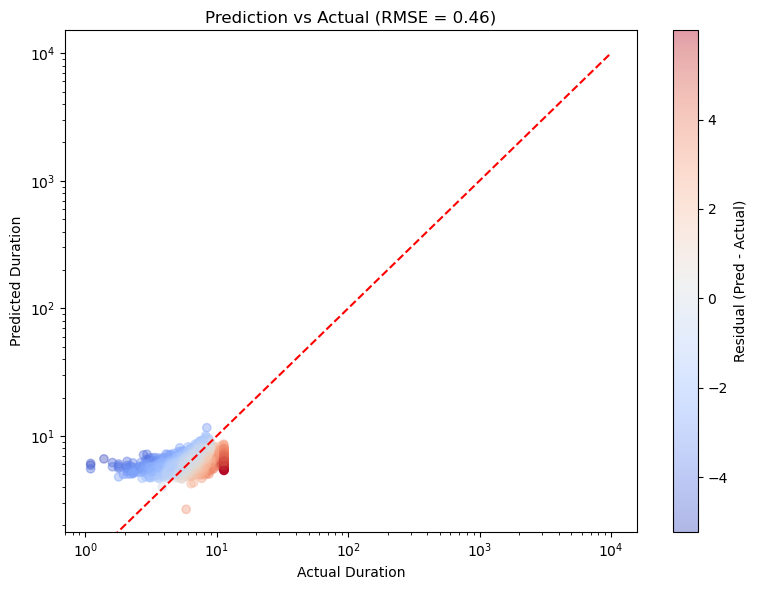

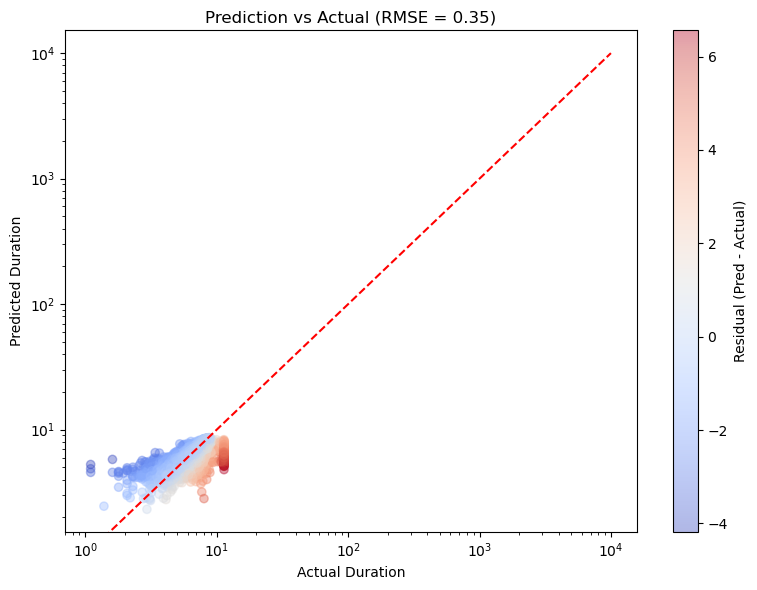

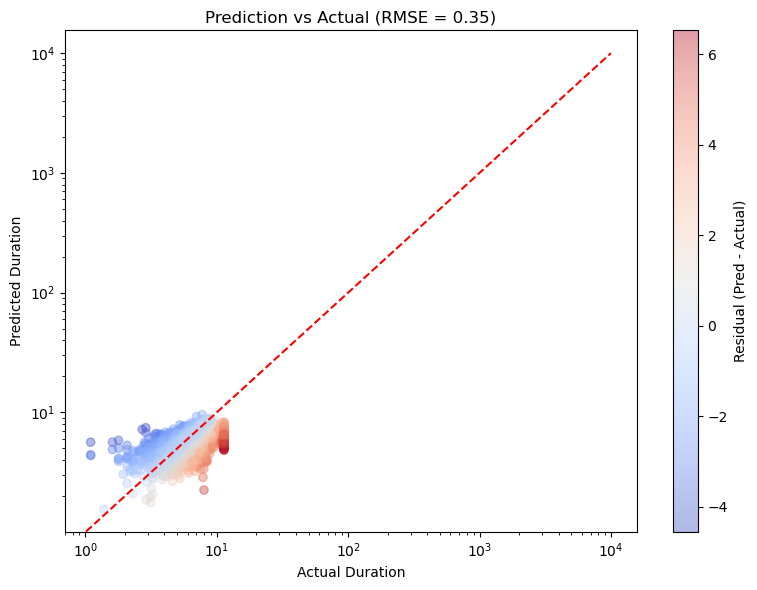

In [39]:
res_poly, preds_poly, rmse_poly = analyze_model(poly_ridge, "Polynomial Ridge")
res_lgbm, preds_lgbm, rmse_lgbm = analyze_model(lgbm, "LightGBM")
res_xgb, preds_xgb, rmse_xgb  = analyze_model(xgb_base, "XGBoost")


plot_residuals(y_valid, preds_poly, rmse_poly, "Polynomial Ridge")
plot_residuals(y_valid, preds_lgbm, rmse_lgbm, "LightGBM")
plot_residuals(y_valid, preds_xgb, rmse_xgb, "XGBoost")


### Feature Importance
- lgbm
    - top 5: `total_distance` (external dataset), `total_travel_time` (external dataset), `work` (day), `minute_oftheday`, `dropoff_latitude`
- xgb
    - top 5: `total_distance` (external dataset), `total_travel_time` (external dataset), `work` (day), `lg_trip`, `turns`, `dropoff_latitude`

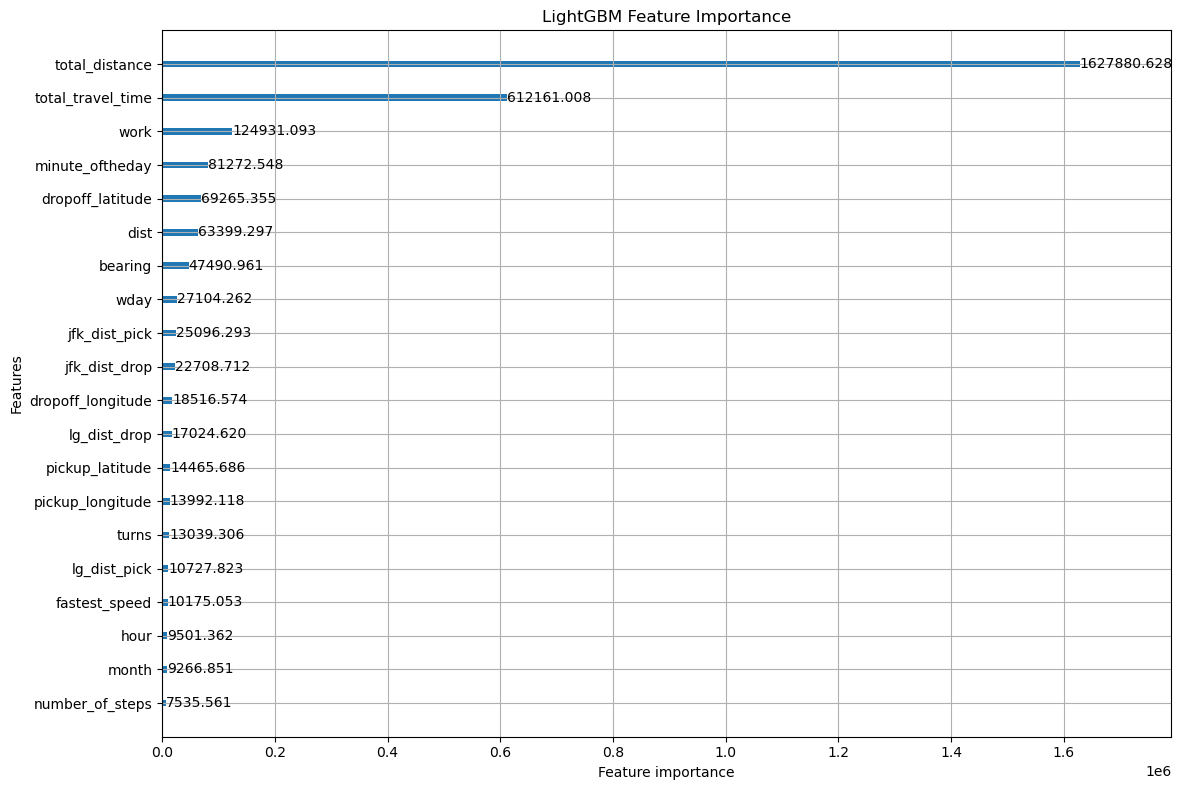

In [49]:
import lightgbm as lgb

ax = lgb.plot_importance(
    stack.named_estimators_['lgbm'],
    max_num_features=20,
    importance_type='gain'
)

fig = ax.figure  # Get the figure object from the Axes
fig.set_size_inches(12, 8)  # Set desired size

plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

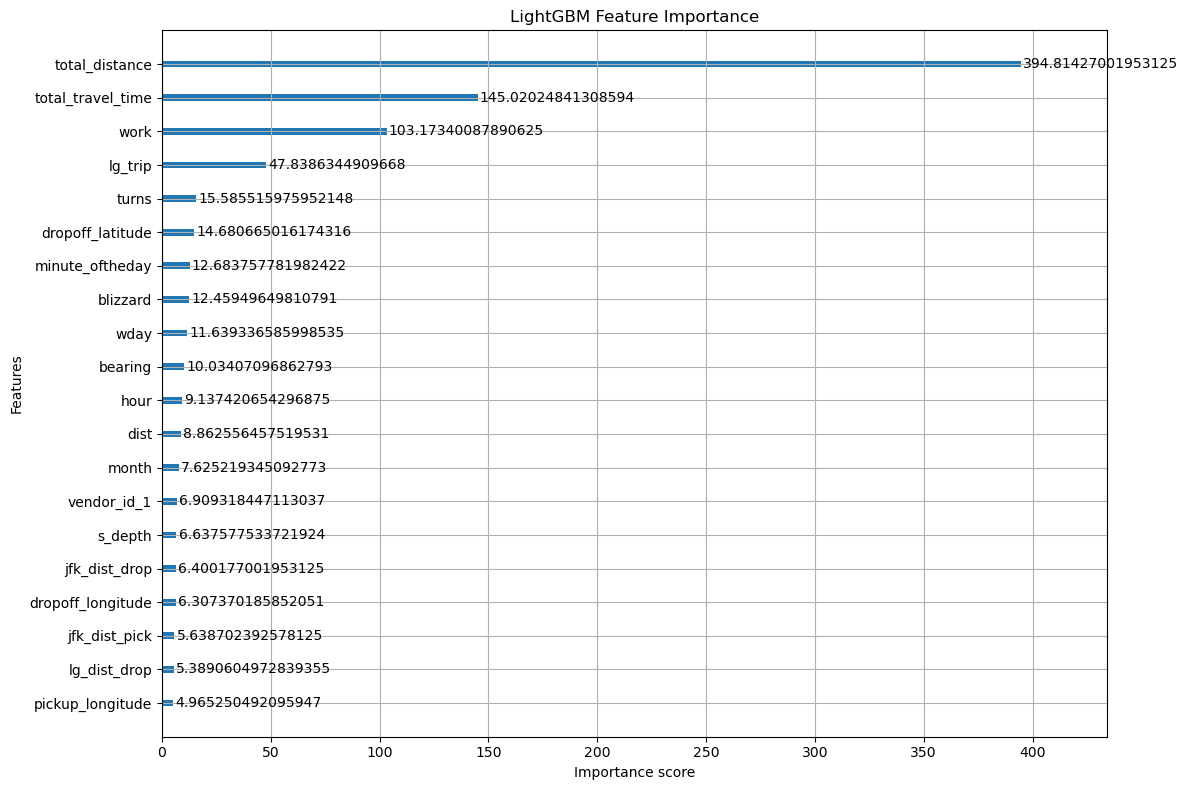

In [ ]:
import xgboost as xgb

ax = xgb.plot_importance(
    stack.named_estimators_['xgb_base'],
    max_num_features=20,
    importance_type='gain'
)

fig = ax.figure  # Get the figure object from the Axes
fig.set_size_inches(12, 8)  # Set desired size

plt.title("XGB Feature Importance")
plt.tight_layout()
plt.show()

### Shap values
1. significance of `total_distance` rises with it's value - airport trips   
    - same goes to `total_travel_time`, `dist` - any distance related feature (avg time to airport)
2. `work` day indicator plays role (when the traffic is big)

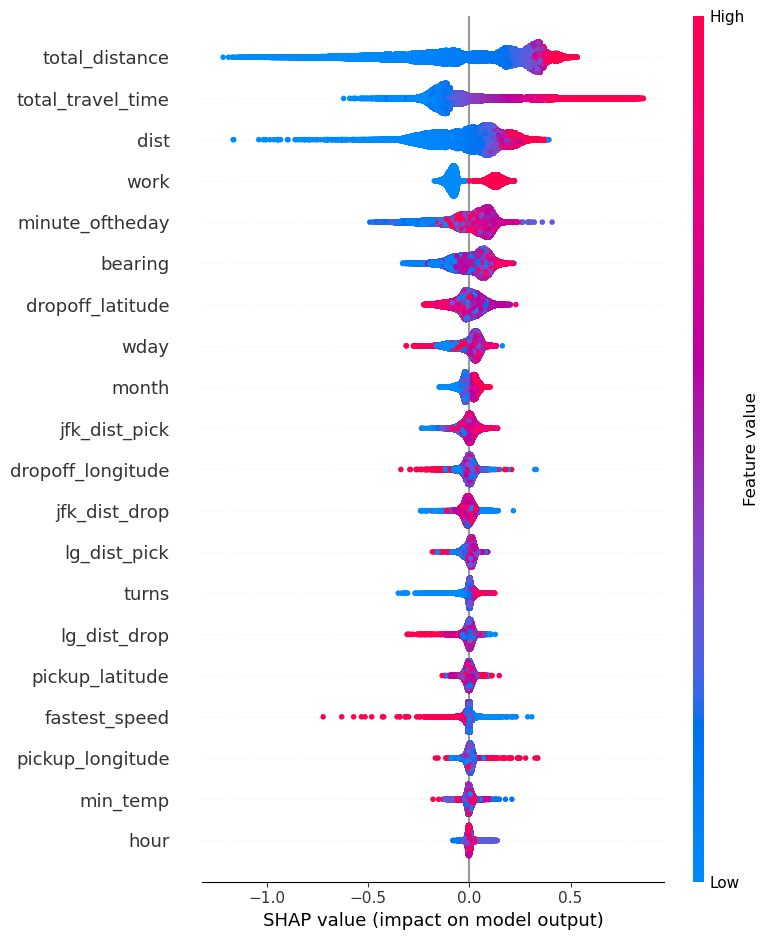

In [53]:
import shap

explainer = shap.Explainer(stack.named_estimators_['lgbm'])
shap_values = explainer(X_valid)
shap.summary_plot(shap_values, X_valid)

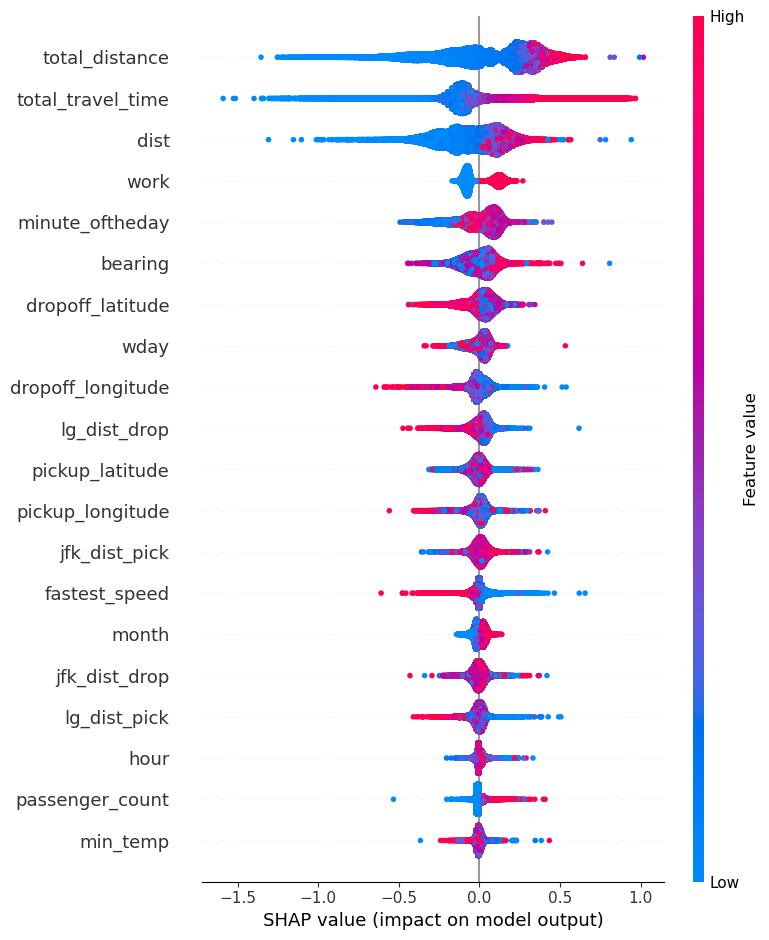

In [54]:
explainer = shap.Explainer(stack.named_estimators_['xgb_base'])
shap_values = explainer(X_valid)
shap.summary_plot(shap_values, X_valid)

## 4. SQL

In [ ]:
# Load container

docker exec -it pg_geo bash
psql -U postgres -d geo_db


# Run the code (creates datasets) 

\set ON_ERROR_STOP on
\set ECHO all
\i /docker-entrypoint-initdb.d/init.sql

In [ ]:
df_clean_SQL = pd.read_csv('data/df_clean.csv')

train_part, valid = train_test_split(df_clean_SQL, train_size=0.8, random_state=4321)
X_train = train_part.drop(columns=['trip_duration'])
y_train = train_part['trip_duration']
X_valid = valid.drop(columns=['trip_duration'])
y_valid = valid['trip_duration']

display(X_train.head(5))
display(X_train.columns)


# ...
# The rest repeats step 3. after data pipeline

## 5. Preparations for full pipeline
- SQL -> docker (python env) -> output (model training results)

In [ ]:
Dependencies

numpy
pandas
matplotlib
IPython
seaborn
plotly
xgboost
catboost
lightgbm
shap
scikit-learn



Python .yml file

In [ ]:
# Use a slim Python image
FROM python:3.10-slim

# Install system libraries needed to compile some data-science packages
RUN apt-get update \
    && apt-get install -y --no-install-recommends \
       build-essential \
       libgomp1 \
    && rm -rf /var/lib/apt/lists/*

# Set working directory
WORKDIR /app

# Copy and install Python dependencies
COPY requirements.txt .
RUN pip install --upgrade pip \
    && pip install --no-cache-dir -r requirements.txt

# Copy your project code
COPY . .

# Default command; replace script.py with your actual entrypoint
CMD ["python", "script.py", "--data", "/data/dataset.csv"]
